In [1]:
import numpy as np
import tensorflow as tf
import os
from matplotlib import image
import math
import matplotlib.pyplot as plt
#from tensorflow.python.framework import ops

In [2]:
def one_hot_encoder(labellist, nb_classes):
    one_hot = np.zeros([len(labellist), nb_classes])
    for i,l in enumerate(labellist):
        one_hot[i][int(l)-1] = 1
    return one_hot

In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [4]:
ftraindir = r'C:\Users\dhecker\Downloads\dice\train'
ftestdir = r'C:\Users\dhecker\Downloads\dice\valid'
IMSIZE = 128

In [5]:
#load training data
dirs = ['d6','d8','d10','d12','d20']
loaded_images = list()
labels = []
for d in dirs:
    files = os.listdir(os.path.join(ftraindir,d))
    for f in files:
        im = image.imread(os.path.join(ftraindir,d,f))
        im = np.resize(im, (IMSIZE,IMSIZE,3))
        loaded_images.append(im) #images as LIST
        
        #print('> loaded %s %s' % (f, im.shape))
        
        #set label
        if f[0:2] == 'd4':
            labels.append(1)
        elif f[0:2] == 'd6':
            labels.append(2)
        elif f[0:2] == 'd8':
            labels.append(3)
        elif f[0:3] == 'd10':
            labels.append(4)
        elif f[0:3] == 'd12':
            labels.append(5)
        elif f[0:3] == 'd20':
            labels.append(6)
            
X_train_orig = np.array(loaded_images)
Y_train_orig = labels
print('loaded %i images and set %i labels' % (X_train_orig.shape[0], len(labels)))

loaded 12337 images and set 12337 labels


In [6]:
#load test data
loaded_images = list()
labels = []
for d in dirs:
    files = os.listdir(os.path.join(ftestdir,d))
    for f in files:
        if f[0] == 'd':
            
            im = image.imread(os.path.join(ftestdir,d,f))
            im = np.resize(im, (IMSIZE,IMSIZE,3))
            loaded_images.append(im)
        
            #set label
            if f[0:2] == 'd4':
                labels.append(1)
            elif f[0:2] == 'd6':
                labels.append(2)
            elif f[0:2] == 'd8':
                labels.append(3)
            elif f[0:3] == 'd10':
                labels.append(4)
            elif f[0:3] == 'd12':
                labels.append(5)
            elif f[0:3] == 'd20':
                labels.append(6)
            
X_test_orig = np.array(loaded_images)
Y_test_orig = labels
print('loaded %i images and set %i labels' % (X_test_orig.shape[0], len(Y_test_orig)))

loaded 1761 images and set 1761 labels


In [7]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = one_hot_encoder(Y_train_orig, 6)
Y_test = one_hot_encoder(Y_test_orig, 6)
print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape)) 
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 12337
number of test examples = 1761
X_train shape: (12337, 128, 128, 3)
Y_train shape: (12337, 6)
X_test.shape: (1761, 128, 128, 3)
Y_test.shape: (1761, 6)


In [8]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X,Y

In [9]:
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [3, 3, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [3, 3, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", [3, 3, 16, 32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3}
    
    return parameters

In [10]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,4,4,1], strides=[1,4,4,1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    
    Z3 = tf.nn.conv2d(P2, W3, strides=[1,1,1,1], padding = 'SAME')
    A3 = tf.nn.relu(Z3)
    P3 = tf.nn.max_pool(A3, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    
    F = tf.contrib.layers.flatten(P3)
    
    Z4 = tf.contrib.layers.fully_connected(F,6, activation_fn=None)
    
    return Z4

In [11]:
def compute_cost(Z4, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = Y))
    
    return cost

In [30]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
         num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _, temp_cost = sess.run(fetches=[optimizer, cost], feed_dict={X: minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)    
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title('Learning rate =' + str(learning_rate))
        plt.show()
        
        predict_op = tf.argmax(Z3,1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y,1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        return train_accuracy, test_accuracy, parameters

In [15]:
def model_varLR(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
         num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    tf.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    learning_rates = []
    
    var_learning_rate = tf.placeholder(tf.float32)
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=var_learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _, temp_cost = sess.run(fetches=[optimizer, cost], feed_dict={X: minibatch_X,
                                                                              Y: minibatch_Y,
                                                                              var_learning_rate: learning_rate})              
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                learning_rates.append(learning_rate)
        
            if epoch == 150:
                learning_rate *= 0.1
                print("learning rate set to: %f" %learning_rate)
            elif epoch == 300:
                learning_rate *= 0.1
                print("learning rate set to: %f" %learning_rate)                
                
        del minibatches
        
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(learning_rates)*1000,'r')
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        #plt.title('Learning rate =' + str(learning_rate))
        plt.title('Learning rate = variable')
        plt.show()
        
        predict_op = tf.argmax(Z3,1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y,1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        evalsize = int(X_train.shape[0]/10)
        train_accuracy = np.float32(0)
        for i in range(10):
            if i < 9:
                evalbatch_X = X_train[evalsize*i:evalsize*(i+1)]
                evalbatch_Y = Y_train[evalsize*i:evalsize*(i+1)]
            else:
                evalbatch_X = X_train[evalsize*9:]
                evalbatch_Y = Y_train[evalsize*9:]
            train_accuracy += accuracy.eval({X: evalbatch_X, Y: evalbatch_Y})        
        
        #train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        train_accuracy = train_accuracy/10
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.411158
Cost after epoch 5: 0.709441
Cost after epoch 10: 0.516603
Cost after epoch 15: 0.436117
Cost after epoch 20: 0.387895
Cost after epoch 25: 0.355597
Cost after epoch 30: 0.337325
Cost after epoch 35: 0.319072
Cost after epoch 40: 0.306671
Cost after epoch 45: 0.282181
Cost after epoch 50: 0.267305
Cost after epoch 55: 0.251201
Cost after epoch 60: 0.267184
Cost after epoch 65: 0.259888
Cost after epoch 70: 0.298191
Cost after epoch 75: 0.242337
Cost after epoch 80: 0.241047
Cost after epoch 85: 0.235361
Cost after epoch 90: 0.220958
Cost after epoch 95: 0.239149
Cost after epoch 100: 0.231293
Cost after epoch 105: 0.206540
Cost after epoch 110: 0.216608
Cost after epoch 115: 0.205459
Cost after epoch 120: 0.239727
Cost after epoch 125: 0.217220
Cost after epoch 130: 0.207645
Cost after epoch 135: 0.231796
Cost after epoch 140: 0.210037
Cost after epoch 145: 0.207499
Cost after epoch 150: 0.204463
learning rate set to: 0.000090
Cost after epoch 155: 0.037963

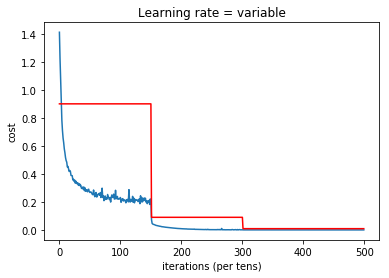

Train Accuracy: 1.0
Test Accuracy: 0.80465645


In [17]:
_,_,parameters = model_varLR(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=500, minibatch_size=2)
#3rd layer 8C, 16C, 32C
#padding SAME
#epochen: 500
#minibatch_size 2
#learning_rate 0.0009, 0.00009 ab epoche==150, 0.000009 ab epoche==300
#bildgröße 128x128x3

Cost after epoch 0: 1.397571
Cost after epoch 5: 0.850050
Cost after epoch 10: 0.637588
Cost after epoch 15: 0.552798
Cost after epoch 20: 0.483585
Cost after epoch 25: 0.446072
Cost after epoch 30: 0.424655
Cost after epoch 35: 0.393786
Cost after epoch 40: 0.355255
Cost after epoch 45: 0.343574
Cost after epoch 50: 0.314258
Cost after epoch 55: 0.317462
Cost after epoch 60: 0.300597
Cost after epoch 65: 0.283472
Cost after epoch 70: 0.252966
Cost after epoch 75: 0.267787
Cost after epoch 80: 0.250533
Cost after epoch 85: 0.261511
Cost after epoch 90: 0.249771
Cost after epoch 95: 0.218243
Cost after epoch 100: 0.234510
Cost after epoch 105: 0.205529
Cost after epoch 110: 0.200624
Cost after epoch 115: 0.190014
Cost after epoch 120: 0.201542
Cost after epoch 125: 0.196947
Cost after epoch 130: 0.255697
Cost after epoch 135: 0.168689
Cost after epoch 140: 0.184596
Cost after epoch 145: 0.166346
Cost after epoch 150: 0.188914
learning rate set to: 0.000090
Cost after epoch 155: 0.109108

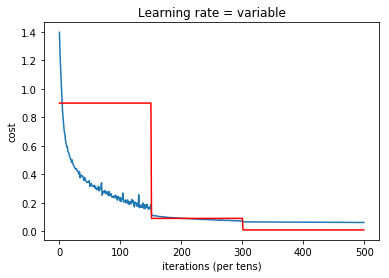

Train Accuracy: 0.9808692932128906
Test Accuracy: 0.8847246


In [16]:
_,_,parameters = model_varLR(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=500, minibatch_size=32)
#3rd layer 8C, 16C, 32C
#padding SAME
#epochen: 500
#minibatch_size 32
#learning_rate 0.0009
#bildgröße 128x128x3


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.378226
Cost after epoch 5: 0.820669
Cost after epoch 10: 0.630194
Cost after epoch 15: 0.516945
Cost after epoch 20: 0.445133
Cost after epoch 25: 0.407574
Cost after epoch 30: 0.369981
Cost after epoch 35: 0.341415
Cost after epoch 40: 0.335084
Cost after epoch 45: 0.315649
Cost after epoch 50: 0.266244
Cost after epoch 55: 0.283795
Cost after epoch 60: 0.257986
Cost after epoch 65: 0.262049
Cost after epoch 70: 0

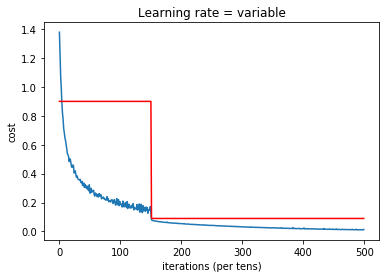

Train Accuracy: 0.9991889953613281
Test Accuracy: 0.84383875


In [13]:
_,_,parameters = model_varLR(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=500, minibatch_size=16)
#3rd layer 8C, 16C, 32C
#padding SAME
#epochen: 1000
#minibatch_size 16
#learning_rate 0.0009
#bildgröße 128x128x3

Cost after epoch 0: 1.470763
Cost after epoch 5: 0.867946
Cost after epoch 10: 0.705276
Cost after epoch 15: 0.636221
Cost after epoch 20: 0.558757
Cost after epoch 25: 0.522188
Cost after epoch 30: 0.479541
Cost after epoch 35: 0.449970
Cost after epoch 40: 0.412163
Cost after epoch 45: 0.421083
Cost after epoch 50: 0.377612
Cost after epoch 55: 0.366399
Cost after epoch 60: 0.350636
Cost after epoch 65: 0.326469
Cost after epoch 70: 0.300575
Cost after epoch 75: 0.298473
Cost after epoch 80: 0.297994
Cost after epoch 85: 0.283516
Cost after epoch 90: 0.280388
Cost after epoch 95: 0.278437
Cost after epoch 100: 0.267564
Cost after epoch 105: 0.251095
Cost after epoch 110: 0.248143
Cost after epoch 115: 0.239251
Cost after epoch 120: 0.240163
Cost after epoch 125: 0.243746
Cost after epoch 130: 0.215888
Cost after epoch 135: 0.226498
Cost after epoch 140: 0.213664
Cost after epoch 145: 0.223014
Cost after epoch 150: 0.212283
Cost after epoch 155: 0.201754
Cost after epoch 160: 0.201918

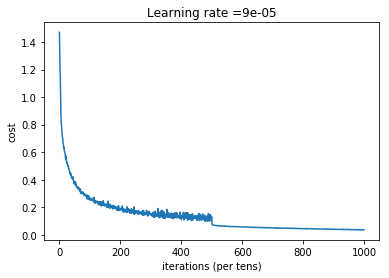

Train Accuracy: 0.9879225
Test Accuracy: 0.8915389


In [23]:
_,_,parameters = model_varLR(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=1000, minibatch_size=32)
#3rd layer 8C, 16C, 32C
#padding SAME
#epochen: 1000
#minibatch_size 32
#learning_rate 0.0009
#bildgröße 96x96x3

Cost after epoch 0: 1.492062
Cost after epoch 5: 1.003327
Cost after epoch 10: 0.788675
Cost after epoch 15: 0.720024
Cost after epoch 20: 0.648515
Cost after epoch 25: 0.599246
Cost after epoch 30: 0.567939
Cost after epoch 35: 0.538657
Cost after epoch 40: 0.500665
Cost after epoch 45: 0.489871
Cost after epoch 50: 0.481066
Cost after epoch 55: 0.445055
Cost after epoch 60: 0.426642
Cost after epoch 65: 0.416682
Cost after epoch 70: 0.402781
Cost after epoch 75: 0.393586
Cost after epoch 80: 0.368102
Cost after epoch 85: 0.365044
Cost after epoch 90: 0.374732
Cost after epoch 95: 0.354163
Cost after epoch 100: 0.345849
Cost after epoch 105: 0.348998
Cost after epoch 110: 0.331188
Cost after epoch 115: 0.335758
Cost after epoch 120: 0.317293
Cost after epoch 125: 0.315159
Cost after epoch 130: 0.301561
Cost after epoch 135: 0.284085
Cost after epoch 140: 0.300190
Cost after epoch 145: 0.285166
Cost after epoch 150: 0.308428
Cost after epoch 155: 0.279965
Cost after epoch 160: 0.275638

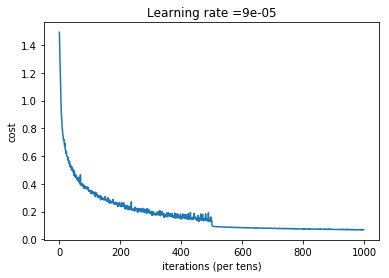

Train Accuracy: 0.97317016
Test Accuracy: 0.9051675


In [19]:
_,_,parameters = model_varLR(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=1000)
#3rd layer 8C, 16C, 32C
#padding SAME
#epochen: 1000
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3

Cost after epoch 0: 1.527559
Cost after epoch 5: 1.094069
Cost after epoch 10: 0.867939
Cost after epoch 15: 0.784715
Cost after epoch 20: 0.711599
Cost after epoch 25: 0.667307
Cost after epoch 30: 0.630037
Cost after epoch 35: 0.612011
Cost after epoch 40: 0.573511
Cost after epoch 45: 0.539474
Cost after epoch 50: 0.525932
Cost after epoch 55: 0.513777
Cost after epoch 60: 0.496444
Cost after epoch 65: 0.489113
Cost after epoch 70: 0.455310
Cost after epoch 75: 0.456990
Cost after epoch 80: 0.436303
Cost after epoch 85: 0.422558
Cost after epoch 90: 0.415630
Cost after epoch 95: 0.431008
Cost after epoch 100: 0.411405
Cost after epoch 105: 0.385945
Cost after epoch 110: 0.387704
Cost after epoch 115: 0.384296
Cost after epoch 120: 0.359020
Cost after epoch 125: 0.362590
Cost after epoch 130: 0.350223
Cost after epoch 135: 0.344945
Cost after epoch 140: 0.344403
Cost after epoch 145: 0.324654
Cost after epoch 150: 0.355173
Cost after epoch 155: 0.307768
Cost after epoch 160: 0.323171

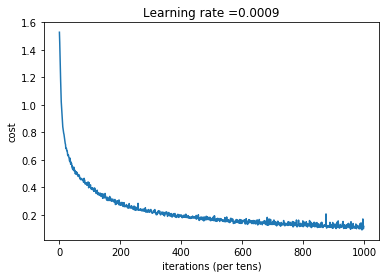

ResourceExhaustedError: OOM when allocating tensor with shape[12337,16,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-42-76b13b98d9aa>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Conv2D', defined at:
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\asyncio\base_events.py", line 528, in run_forever
    self._run_once()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\asyncio\base_events.py", line 1764, in _run_once
    handle._run()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-8cf280ba4f12>", line 1, in <module>
    _,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=1000)
  File "<ipython-input-39-f50522ec3842>", line 13, in model
    Z3 = forward_propagation(X, parameters)
  File "<ipython-input-42-76b13b98d9aa>", line 6, in forward_propagation
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding = 'SAME')
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1026, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[12337,16,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-42-76b13b98d9aa>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [43]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=1000)
#3rd layer 16C, 16C, 16C
#padding SAME
#epochen: 1000
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3

Cost after epoch 0: 1.519579
Cost after epoch 5: 0.963350
Cost after epoch 10: 0.800970
Cost after epoch 15: 0.713170
Cost after epoch 20: 0.653082
Cost after epoch 25: 0.606586
Cost after epoch 30: 0.571338
Cost after epoch 35: 0.537623
Cost after epoch 40: 0.508545
Cost after epoch 45: 0.481938
Cost after epoch 50: 0.456577
Cost after epoch 55: 0.468372
Cost after epoch 60: 0.462010
Cost after epoch 65: 0.425727
Cost after epoch 70: 0.397606
Cost after epoch 75: 0.391940
Cost after epoch 80: 0.390925
Cost after epoch 85: 0.370519
Cost after epoch 90: 0.367741
Cost after epoch 95: 0.357708
Cost after epoch 100: 0.328570
Cost after epoch 105: 0.327194
Cost after epoch 110: 0.325935
Cost after epoch 115: 0.320023
Cost after epoch 120: 0.310676
Cost after epoch 125: 0.307677
Cost after epoch 130: 0.311489
Cost after epoch 135: 0.302718
Cost after epoch 140: 0.284089
Cost after epoch 145: 0.288648
Cost after epoch 150: 0.279029
Cost after epoch 155: 0.263502
Cost after epoch 160: 0.275974

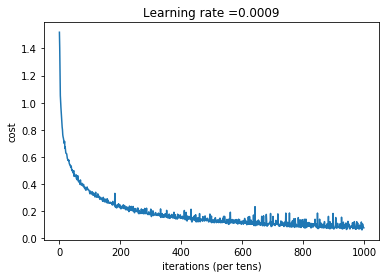

Train Accuracy: 0.9764124
Test Accuracy: 0.8784781


In [37]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=1000)
#3rd layer 8C, 16C, 32C
#padding SAME
#epochen: 1000
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3

Cost after epoch 0: 1.527983
Cost after epoch 5: 1.233435
Cost after epoch 10: 1.075652
Cost after epoch 15: 0.964927
Cost after epoch 20: 0.902652
Cost after epoch 25: 0.859997
Cost after epoch 30: 0.845438
Cost after epoch 35: 0.814071
Cost after epoch 40: 0.778687
Cost after epoch 45: 0.751674
Cost after epoch 50: 0.734153
Cost after epoch 55: 0.714787
Cost after epoch 60: 0.709187
Cost after epoch 65: 0.687250
Cost after epoch 70: 0.688815
Cost after epoch 75: 0.658979
Cost after epoch 80: 0.653555
Cost after epoch 85: 0.643898
Cost after epoch 90: 0.645568
Cost after epoch 95: 0.647538
Cost after epoch 100: 0.621204
Cost after epoch 105: 0.611384
Cost after epoch 110: 0.610433
Cost after epoch 115: 0.599747
Cost after epoch 120: 0.590228
Cost after epoch 125: 0.596926
Cost after epoch 130: 0.579982
Cost after epoch 135: 0.572383
Cost after epoch 140: 0.569199
Cost after epoch 145: 0.564264
Cost after epoch 150: 0.568648
Cost after epoch 155: 0.554152
Cost after epoch 160: 0.541459

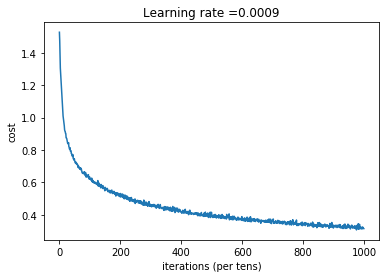

Train Accuracy: 0.87800926
Test Accuracy: 0.84213513


In [35]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=1000)
#3rd layer 8C, 8C, 8C
#padding SAME
#epochen: 1000
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3

Cost after epoch 0: 1.504258
Cost after epoch 5: 1.077644
Cost after epoch 10: 0.936061
Cost after epoch 15: 0.884408
Cost after epoch 20: 0.837695
Cost after epoch 25: 0.788823
Cost after epoch 30: 0.761587
Cost after epoch 35: 0.747112
Cost after epoch 40: 0.718982
Cost after epoch 45: 0.697236
Cost after epoch 50: 0.684583
Cost after epoch 55: 0.680889
Cost after epoch 60: 0.669734
Cost after epoch 65: 0.660435
Cost after epoch 70: 0.643485
Cost after epoch 75: 0.625573
Cost after epoch 80: 0.625698
Cost after epoch 85: 0.607927
Cost after epoch 90: 0.609569
Cost after epoch 95: 0.619858
Cost after epoch 100: 0.600659
Cost after epoch 105: 0.589112
Cost after epoch 110: 0.587488
Cost after epoch 115: 0.581631
Cost after epoch 120: 0.574283
Cost after epoch 125: 0.561191
Cost after epoch 130: 0.570864
Cost after epoch 135: 0.549121
Cost after epoch 140: 0.555907
Cost after epoch 145: 0.550440
Cost after epoch 150: 0.549284
Cost after epoch 155: 0.544760
Cost after epoch 160: 0.532133

Cost after epoch 1315: 0.280036
Cost after epoch 1320: 0.286279
Cost after epoch 1325: 0.281511
Cost after epoch 1330: 0.272295
Cost after epoch 1335: 0.288673
Cost after epoch 1340: 0.276999
Cost after epoch 1345: 0.277073
Cost after epoch 1350: 0.288347
Cost after epoch 1355: 0.268423
Cost after epoch 1360: 0.285286
Cost after epoch 1365: 0.279809
Cost after epoch 1370: 0.273477
Cost after epoch 1375: 0.273963
Cost after epoch 1380: 0.272313
Cost after epoch 1385: 0.276099
Cost after epoch 1390: 0.283295
Cost after epoch 1395: 0.292231
Cost after epoch 1400: 0.272835
Cost after epoch 1405: 0.282043
Cost after epoch 1410: 0.273679
Cost after epoch 1415: 0.273335
Cost after epoch 1420: 0.271961
Cost after epoch 1425: 0.274125
Cost after epoch 1430: 0.287306
Cost after epoch 1435: 0.279487
Cost after epoch 1440: 0.276825
Cost after epoch 1445: 0.268604
Cost after epoch 1450: 0.268545
Cost after epoch 1455: 0.268236
Cost after epoch 1460: 0.263176
Cost after epoch 1465: 0.270033
Cost aft

Cost after epoch 2600: 0.223348
Cost after epoch 2605: 0.229345
Cost after epoch 2610: 0.226852
Cost after epoch 2615: 0.225917
Cost after epoch 2620: 0.239840
Cost after epoch 2625: 0.232819
Cost after epoch 2630: 0.238907
Cost after epoch 2635: 0.226838
Cost after epoch 2640: 0.230665
Cost after epoch 2645: 0.224758
Cost after epoch 2650: 0.267648
Cost after epoch 2655: 0.220305
Cost after epoch 2660: 0.236559
Cost after epoch 2665: 0.221265
Cost after epoch 2670: 0.231725
Cost after epoch 2675: 0.220561
Cost after epoch 2680: 0.228934
Cost after epoch 2685: 0.218433
Cost after epoch 2690: 0.244900
Cost after epoch 2695: 0.232867
Cost after epoch 2700: 0.236013
Cost after epoch 2705: 0.232824
Cost after epoch 2710: 0.225644
Cost after epoch 2715: 0.222085
Cost after epoch 2720: 0.262686
Cost after epoch 2725: 0.217427
Cost after epoch 2730: 0.214026
Cost after epoch 2735: 0.221467
Cost after epoch 2740: 0.218026
Cost after epoch 2745: 0.230763
Cost after epoch 2750: 0.224160
Cost aft

Cost after epoch 3885: 0.198752
Cost after epoch 3890: 0.206023
Cost after epoch 3895: 0.204748
Cost after epoch 3900: 0.204522
Cost after epoch 3905: 0.194906
Cost after epoch 3910: 0.195233
Cost after epoch 3915: 0.190745
Cost after epoch 3920: 0.208242
Cost after epoch 3925: 0.193868
Cost after epoch 3930: 0.192380
Cost after epoch 3935: 0.201884
Cost after epoch 3940: 0.195682
Cost after epoch 3945: 0.205091
Cost after epoch 3950: 0.194007
Cost after epoch 3955: 0.206002
Cost after epoch 3960: 0.195593
Cost after epoch 3965: 0.206405
Cost after epoch 3970: 0.202745
Cost after epoch 3975: 0.221657
Cost after epoch 3980: 0.205307
Cost after epoch 3985: 0.200911
Cost after epoch 3990: 0.196693
Cost after epoch 3995: 0.197727
Cost after epoch 4000: 0.202140
Cost after epoch 4005: 0.207124
Cost after epoch 4010: 0.193398
Cost after epoch 4015: 0.225996
Cost after epoch 4020: 0.185530
Cost after epoch 4025: 0.190672
Cost after epoch 4030: 0.201108
Cost after epoch 4035: 0.198730
Cost aft

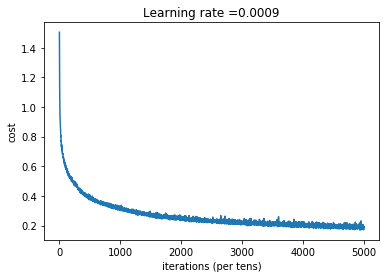

Train Accuracy: 0.9081624
Test Accuracy: 0.8040886


In [28]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=5000)
#padding VALID
#epochen: 1000
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3

Cost after epoch 0: 1.503934
Cost after epoch 5: 1.079678
Cost after epoch 10: 0.948343
Cost after epoch 15: 0.894418
Cost after epoch 20: 0.861680
Cost after epoch 25: 0.817216
Cost after epoch 30: 0.797644
Cost after epoch 35: 0.785361
Cost after epoch 40: 0.761509
Cost after epoch 45: 0.734676
Cost after epoch 50: 0.723195
Cost after epoch 55: 0.717010
Cost after epoch 60: 0.710199
Cost after epoch 65: 0.697814
Cost after epoch 70: 0.680179
Cost after epoch 75: 0.663991
Cost after epoch 80: 0.662145
Cost after epoch 85: 0.651687
Cost after epoch 90: 0.649550
Cost after epoch 95: 0.653930
Cost after epoch 100: 0.639864
Cost after epoch 105: 0.625225
Cost after epoch 110: 0.623784
Cost after epoch 115: 0.620590
Cost after epoch 120: 0.617941
Cost after epoch 125: 0.608985
Cost after epoch 130: 0.613632
Cost after epoch 135: 0.593059
Cost after epoch 140: 0.605015
Cost after epoch 145: 0.601998
Cost after epoch 150: 0.594963
Cost after epoch 155: 0.594729
Cost after epoch 160: 0.588257

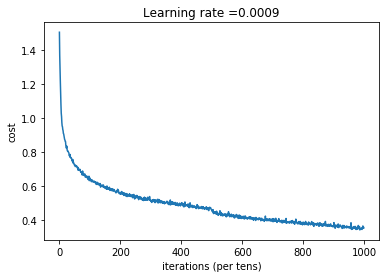

Train Accuracy: 0.8515036
Test Accuracy: 0.79443496


In [27]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=1000)
#padding VALID
#epochen: 1000
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3

Cost after epoch 0: 1.504143
Cost after epoch 5: 1.073764
Cost after epoch 10: 0.946541
Cost after epoch 15: 0.887548
Cost after epoch 20: 0.848186
Cost after epoch 25: 0.803398
Cost after epoch 30: 0.784268
Cost after epoch 35: 0.772741
Cost after epoch 40: 0.746183
Cost after epoch 45: 0.727428
Cost after epoch 50: 0.705455
Cost after epoch 55: 0.709354
Cost after epoch 60: 0.697737
Cost after epoch 65: 0.688460
Cost after epoch 70: 0.671070
Cost after epoch 75: 0.660915
Cost after epoch 80: 0.656801
Cost after epoch 85: 0.645170
Cost after epoch 90: 0.640253
Cost after epoch 95: 0.656085
Cost after epoch 100: 0.632326
Cost after epoch 105: 0.620586
Cost after epoch 110: 0.629304
Cost after epoch 115: 0.616152
Cost after epoch 120: 0.606822
Cost after epoch 125: 0.606862
Cost after epoch 130: 0.605713
Cost after epoch 135: 0.589380
Cost after epoch 140: 0.594585
Cost after epoch 145: 0.588870
Cost after epoch 150: 0.590072
Cost after epoch 155: 0.572801
Cost after epoch 160: 0.568510

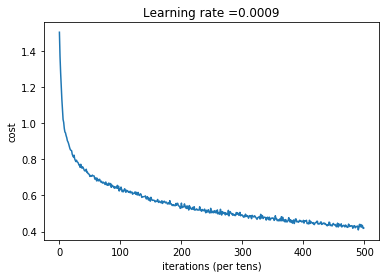

Train Accuracy: 0.83277947
Test Accuracy: 0.7825099


In [26]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=500)
#padding VALID
#epochen: 500
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3

Cost after epoch 0: 1.470373
Cost after epoch 5: 0.976990
Cost after epoch 10: 0.813165
Cost after epoch 15: 0.735810
Cost after epoch 20: 0.670513
Cost after epoch 25: 0.624138
Cost after epoch 30: 0.625398
Cost after epoch 35: 0.572325
Cost after epoch 40: 0.544338
Cost after epoch 45: 0.510017
Cost after epoch 50: 0.473889
Cost after epoch 55: 0.454988
Cost after epoch 60: 0.463673
Cost after epoch 65: 0.438758
Cost after epoch 70: 0.411249
Cost after epoch 75: 0.400373
Cost after epoch 80: 0.389119
Cost after epoch 85: 0.388320
Cost after epoch 90: 0.378073
Cost after epoch 95: 0.366298
Cost after epoch 100: 0.348376
Cost after epoch 105: 0.355971
Cost after epoch 110: 0.354888
Cost after epoch 115: 0.340215
Cost after epoch 120: 0.336702
Cost after epoch 125: 0.314335
Cost after epoch 130: 0.319466
Cost after epoch 135: 0.292254
Cost after epoch 140: 0.304695
Cost after epoch 145: 0.292620
Cost after epoch 150: 0.307489
Cost after epoch 155: 0.290860
Cost after epoch 160: 0.286431

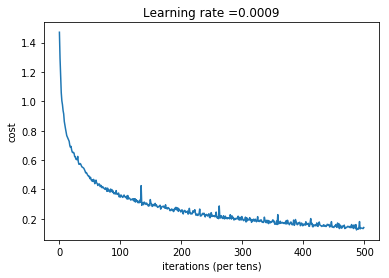

ResourceExhaustedError: OOM when allocating tensor with shape[12337,8,96,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-11-b17dc7b2155e>:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean_1 (defined at <ipython-input-13-f50522ec3842>:49) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Conv2D', defined at:
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\asyncio\base_events.py", line 528, in run_forever
    self._run_once()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\asyncio\base_events.py", line 1764, in _run_once
    handle._run()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-5c3493b17201>", line 1, in <module>
    _,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=500)
  File "<ipython-input-13-f50522ec3842>", line 13, in model
    Z3 = forward_propagation(X, parameters)
  File "<ipython-input-11-b17dc7b2155e>", line 5, in forward_propagation
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding = 'SAME')
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1026, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\dhecker\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[12337,8,96,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-11-b17dc7b2155e>:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean_1 (defined at <ipython-input-13-f50522ec3842>:49) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [20]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=500)
#epochen: 500
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 96x96x3

Cost after epoch 0: 1.466854
Cost after epoch 5: 0.978859
Cost after epoch 10: 0.850361
Cost after epoch 15: 0.804033
Cost after epoch 20: 0.769088
Cost after epoch 25: 0.727603
Cost after epoch 30: 0.701145
Cost after epoch 35: 0.681066
Cost after epoch 40: 0.667379
Cost after epoch 45: 0.636599
Cost after epoch 50: 0.612924
Cost after epoch 55: 0.607819
Cost after epoch 60: 0.586551
Cost after epoch 65: 0.575754
Cost after epoch 70: 0.552820
Cost after epoch 75: 0.533855
Cost after epoch 80: 0.529829
Cost after epoch 85: 0.512604
Cost after epoch 90: 0.496799
Cost after epoch 95: 0.491987
Cost after epoch 100: 0.477072
Cost after epoch 105: 0.482054
Cost after epoch 110: 0.455594
Cost after epoch 115: 0.457030
Cost after epoch 120: 0.449346
Cost after epoch 125: 0.444394
Cost after epoch 130: 0.429897
Cost after epoch 135: 0.417423
Cost after epoch 140: 0.413604
Cost after epoch 145: 0.423631
Cost after epoch 150: 0.423327
Cost after epoch 155: 0.402934
Cost after epoch 160: 0.396394

Cost after epoch 1315: 0.148243
Cost after epoch 1320: 0.163476
Cost after epoch 1325: 0.158679
Cost after epoch 1330: 0.151283
Cost after epoch 1335: 0.144316
Cost after epoch 1340: 0.135282
Cost after epoch 1345: 0.152350
Cost after epoch 1350: 0.156855
Cost after epoch 1355: 0.171685
Cost after epoch 1360: 0.149367
Cost after epoch 1365: 0.137203
Cost after epoch 1370: 0.138886
Cost after epoch 1375: 0.137173
Cost after epoch 1380: 0.139616
Cost after epoch 1385: 0.145321
Cost after epoch 1390: 0.137229
Cost after epoch 1395: 0.139314
Cost after epoch 1400: 0.138338
Cost after epoch 1405: 0.142522
Cost after epoch 1410: 0.138190
Cost after epoch 1415: 0.142914
Cost after epoch 1420: 0.130537
Cost after epoch 1425: 0.152151
Cost after epoch 1430: 0.130711
Cost after epoch 1435: 0.153274
Cost after epoch 1440: 0.142015
Cost after epoch 1445: 0.140698
Cost after epoch 1450: 0.136848
Cost after epoch 1455: 0.130624
Cost after epoch 1460: 0.130811
Cost after epoch 1465: 0.128322
Cost aft

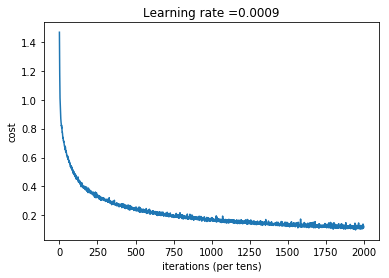

Train Accuracy: 0.91116154
Test Accuracy: 0.8285065


In [15]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=2000)
#epochen: 2000
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.469880
Cost after epoch 5: 0.990248
Cost after epoch 10: 0.846777
Cost after epoch 15: 0.800654
Cost after epoch 20: 0.766804
Cost after epoch 25: 0.734725
Cost after epoch 30: 0.702603
Cost after epoch 35: 0.685844
Cost after epoch 40: 0.660343
Cost after epoch 45: 0.637613
Cost after epoch 50: 0.618710
Cost after epoch 55: 0.618970
Cost after epoch 60: 0.601898
Cost after epoch 65: 0.585135
Cost after epoch 70: 0

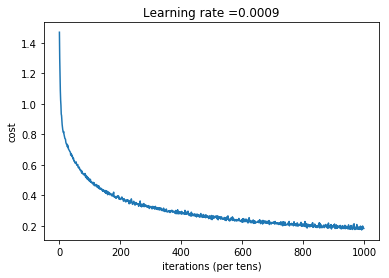

Train Accuracy: 0.9183756
Test Accuracy: 0.85292447


In [14]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=1000)
#epochen: 1000
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3

Cost after epoch 0: 1.467149
Cost after epoch 5: 0.982853
Cost after epoch 10: 0.855952
Cost after epoch 15: 0.815278
Cost after epoch 20: 0.788978
Cost after epoch 25: 0.741673
Cost after epoch 30: 0.709964
Cost after epoch 35: 0.697776
Cost after epoch 40: 0.670445
Cost after epoch 45: 0.646105
Cost after epoch 50: 0.624342
Cost after epoch 55: 0.621273
Cost after epoch 60: 0.605830
Cost after epoch 65: 0.588356
Cost after epoch 70: 0.581281
Cost after epoch 75: 0.549949
Cost after epoch 80: 0.543947
Cost after epoch 85: 0.540445
Cost after epoch 90: 0.520970
Cost after epoch 95: 0.525416
Cost after epoch 100: 0.498725
Cost after epoch 105: 0.503474
Cost after epoch 110: 0.490274
Cost after epoch 115: 0.478422
Cost after epoch 120: 0.473571
Cost after epoch 125: 0.474450
Cost after epoch 130: 0.456742
Cost after epoch 135: 0.445288
Cost after epoch 140: 0.446548
Cost after epoch 145: 0.447690
Cost after epoch 150: 0.442000
Cost after epoch 155: 0.429552
Cost after epoch 160: 0.430718

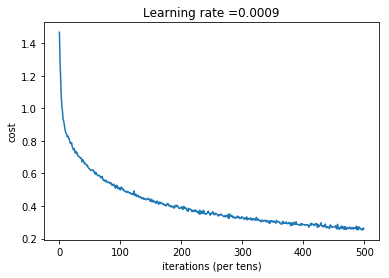

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.90265054
Test Accuracy: 0.84497446


In [31]:
#REGULARISIERUNG hinzufügen!
_,_,parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.0009, num_epochs=500)
#epochen: 500
#minibatch_size 64
#learning_rate 0.0009
#bildgröße 64x64x3

Cost after epoch 0: 1.474501
Cost after epoch 5: 1.189137
Cost after epoch 10: 1.053347
Cost after epoch 15: 0.931922
Cost after epoch 20: 0.871151
Cost after epoch 25: 0.838660
Cost after epoch 30: 0.842068
Cost after epoch 35: 0.775571
Cost after epoch 40: 0.801034
Cost after epoch 45: 0.794858
Cost after epoch 50: 0.760890
Cost after epoch 55: 0.755022
Cost after epoch 60: 0.722542
Cost after epoch 65: 0.714085
Cost after epoch 70: 0.754874
Cost after epoch 75: 0.709045
Cost after epoch 80: 0.723608
Cost after epoch 85: 0.761551
Cost after epoch 90: 0.710984
Cost after epoch 95: 0.695347
Cost after epoch 100: 0.670284
Cost after epoch 105: 0.672941
Cost after epoch 110: 0.684331
Cost after epoch 115: 0.667231
Cost after epoch 120: 0.656781
Cost after epoch 125: 0.721210
Cost after epoch 130: 0.647732
Cost after epoch 135: 0.658569
Cost after epoch 140: 0.644940
Cost after epoch 145: 0.691627
Cost after epoch 150: 0.716761
Cost after epoch 155: 0.722205
Cost after epoch 160: 0.673423

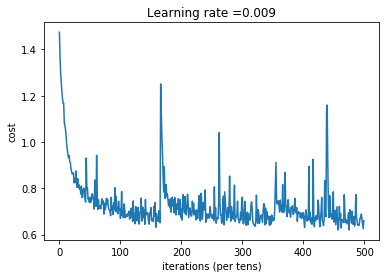

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.75439733
Test Accuracy: 0.6507666


In [29]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=500)
#epochen: 500
#minibatch_size 64
#learning_rate 0.009
#bildgröße 64x64x3

Cost after epoch 0: 1.549604
Cost after epoch 5: 1.184276
Cost after epoch 10: 1.020830
Cost after epoch 15: 0.930656
Cost after epoch 20: 0.841125
Cost after epoch 25: 0.789692
Cost after epoch 30: 0.740006
Cost after epoch 35: 0.699175
Cost after epoch 40: 0.666996
Cost after epoch 45: 0.633705
Cost after epoch 50: 0.637221
Cost after epoch 55: 0.624513
Cost after epoch 60: 0.594859
Cost after epoch 65: 0.564402
Cost after epoch 70: 0.522464
Cost after epoch 75: 0.517737
Cost after epoch 80: 0.539365
Cost after epoch 85: 0.523087
Cost after epoch 90: 0.529260
Cost after epoch 95: 0.530527


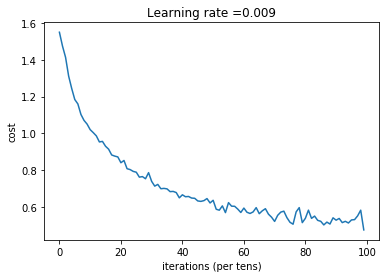

Tensor("Mean_1:0", shape=(), dtype=float32)


ResourceExhaustedError: OOM when allocating tensor with shape[12337,3,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean_1 (defined at <ipython-input-18-00a1cd29d734>:49) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [24]:
#Out Of Memery crash!
_,_,parameters = model(X_train, Y_train, X_test, Y_test)
#minibatch_size 64
#learning_rate 0.009
#bildgröße 128x128x3

Cost after epoch 0: 1.474170
Cost after epoch 5: 1.233531
Cost after epoch 10: 1.118652
Cost after epoch 15: 1.027834
Cost after epoch 20: 0.937278
Cost after epoch 25: 0.880178
Cost after epoch 30: 0.848644
Cost after epoch 35: 0.847616
Cost after epoch 40: 0.813849
Cost after epoch 45: 0.770973
Cost after epoch 50: 0.766580
Cost after epoch 55: 0.770824
Cost after epoch 60: 0.745534
Cost after epoch 65: 0.722064
Cost after epoch 70: 0.710383
Cost after epoch 75: 0.712483
Cost after epoch 80: 0.684173
Cost after epoch 85: 0.705026
Cost after epoch 90: 0.721732
Cost after epoch 95: 0.672266


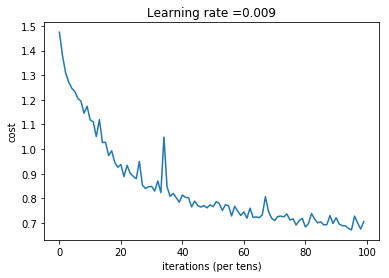

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.71508473
Test Accuracy: 0.6394094


In [19]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test)
#minibatch_size 64
#learning_rate 0.009
#Bildgröße 64x64x3

In [43]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
